In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
(Path.cwd().parent)

PosixPath('/home/ubuntu/varios/skforecast')

In [2]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.plot import plot_residuals
from skforecast.utils import multivariate_time_series_corr
from skforecast.plot import plot_multivariate_time_series_corr
#from skforecast.plot import plot_prediction_distributions

# Plot Residuals

In [3]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv')
data = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
data['fecha'] = pd.to_datetime(data['fecha'], format='%Y/%m/%d')
data = data.set_index('fecha')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data.sort_index()

In [4]:
# Backtest forecaster with initial train
# ==============================================================================
n_backtest = 36*3
data_train = data[:-n_backtest]
data_test  = data[-n_backtest:]

forecaster = ForecasterAutoreg(
                regressor = Ridge(),
                lags      = 5 
             )

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data.y,
                                    initial_train_size = len(data_train),
                                    steps      = 36,
                                    metric     = 'mean_squared_error',
                                    verbose    = False
                               )

In [5]:
residuals = predictions_backtest['pred'] - data_test['y']

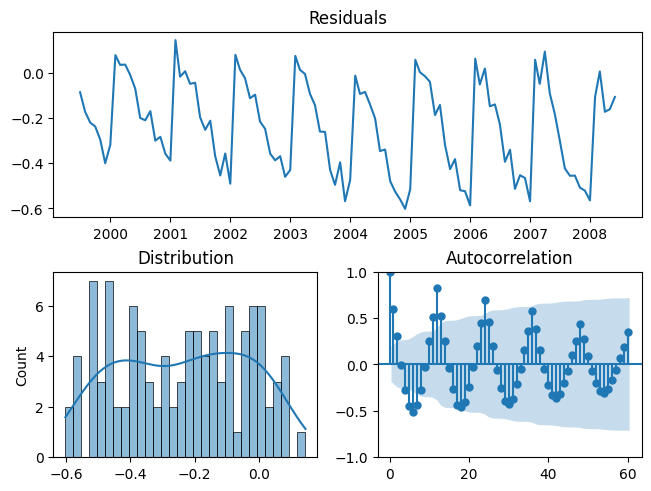

In [6]:
plot_residuals(residuals=residuals)

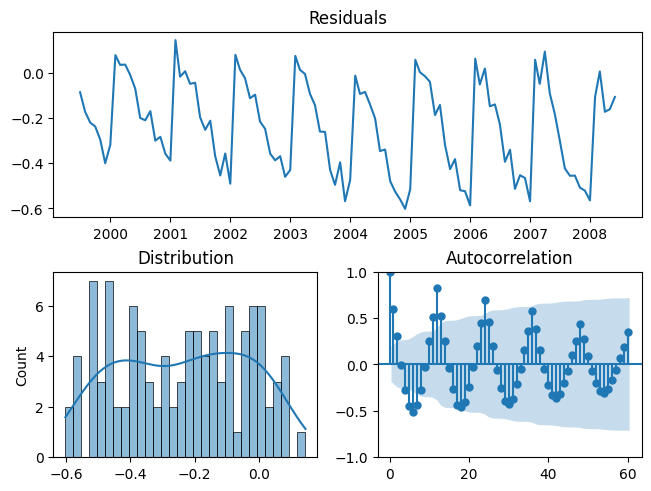

In [7]:
plot_residuals(y_true=data_test['y'], y_pred=predictions_backtest['pred'])

# multivariate_time_series_corr 

In [8]:
# Data download
# ==============================================================================
url = (
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/'
    'Estadistica-machine-learning-python/master/data/air_quality_valencia.csv'
)
data = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')
data = data.set_index('datetime')
data = data.drop(columns=['veloc.', 'direc.'])
data = data.asfreq('H')
data = data.sort_index()
data = data.loc['2021-01-01 00:00:00': '2021-12-31 11:00:00']

# Aggregating in 1D intervals
# ==============================================================================
data = data.resample(rule='D', closed='left', label ='left').mean()
data.head()

# Missing imputation with rolling mean
# ==============================================================================
data['pm2.5'] = data['pm2.5'].fillna(data['pm2.5'].rolling(window='25d', center=True, axis=0).mean())
data['pm10']  = data['pm10'].fillna(data['pm10'].rolling(window='25d', center=True, axis=0).mean())
data['co']    = data['co'].fillna(data['co'].rolling(window='10d', center=True, axis=0).mean())
data['o3']    = data['o3'].fillna(data['o3'].rolling(window='5d', center=True, axis=0).mean())
data['so2']   = data['so2'].fillna(data['so2'].rolling(window='10d', center=True, axis=0).mean())

data= pd.concat([data,data,data,data,data])

In [9]:
corr = multivariate_time_series_corr(
    time_series = data['pm2.5'],
    other       = data,
    lags        = 5
)
corr

,pm2.5,co,no,no2,pm10,nox,o3,so2
lag,,,,,,,,
0,1.000000,-0.050437,0.358713,0.427705,0.835836,0.435800,-0.260211,-0.123025
1,0.774216,-0.099094,0.228872,0.386544,0.696288,0.350768,-0.203467,-0.131022
2,0.541201,-0.076636,0.171215,0.283146,0.548634,0.259532,-0.181258,-0.126705
3,0.385159,-0.049723,0.063409,0.121179,0.429336,0.108291,-0.105378,-0.123055
4,0.305035,-0.036743,0.009427,0.012708,0.357420,0.014990,-0.043324,-0.121805


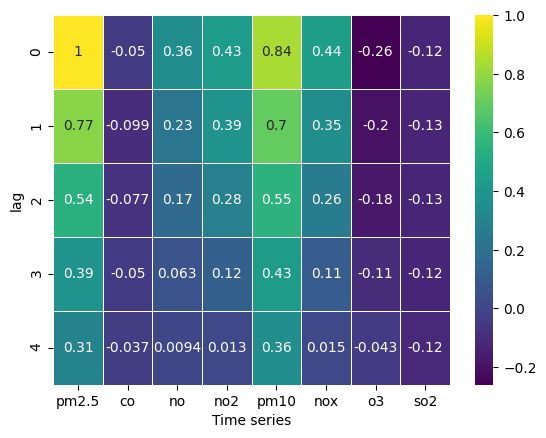

In [10]:
_ = plot_multivariate_time_series_corr(corr)

# Ridge Plot

In [11]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv')
data = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
data['fecha'] = pd.to_datetime(data['fecha'], format='%Y/%m/%d')
data = data.set_index('fecha')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data.sort_index()

In [12]:
forecaster = ForecasterAutoreg(
                regressor = Ridge(),
                lags      = 5 
             )
forecaster.fit(y=data.y)
pred = forecaster.predict_bootstrapping(steps=10)
pred

,pred_boot_0,pred_boot_1,pred_boot_2,pred_boot_3,pred_boot_4,pred_boot_5,pred_boot_6,pred_boot_7,pred_boot_8,pred_boot_9,...,pred_boot_490,pred_boot_491,pred_boot_492,pred_boot_493,pred_boot_494,pred_boot_495,pred_boot_496,pred_boot_497,pred_boot_498,pred_boot_499
2008-07-01,0.728822,0.737767,0.803769,0.735674,0.806414,0.833497,0.703955,0.957734,0.743416,0.828267,...,1.009476,0.984308,0.871057,0.382840,0.823742,0.984484,0.734131,0.929966,0.851741,0.833465
2008-08-01,0.922899,0.947186,0.789037,0.879750,0.906976,0.808887,0.753895,0.998746,0.675858,0.831930,...,0.871087,1.030537,0.785598,0.459338,0.869021,0.854388,0.801924,0.837748,0.873218,0.757491
2008-09-01,0.937284,0.482471,1.010562,0.792776,0.771851,0.402672,0.776309,1.100611,0.772435,0.846785,...,0.808972,0.934550,0.980734,0.738247,0.874099,0.865017,0.745425,0.812253,0.934086,0.937548
2008-10-01,0.498857,0.717546,0.880583,0.961407,0.433091,0.535335,0.297042,0.908873,0.940165,0.883530,...,0.760472,0.928860,0.982886,0.709689,0.880510,0.918018,0.678616,0.375478,0.922542,1.040754
2008-11-01,0.709817,0.884795,0.896081,0.909852,0.587060,0.491967,0.478518,0.918423,0.860444,0.871596,...,0.756610,1.036247,0.520965,0.715885,0.927006,0.982090,0.619778,0.695103,0.874987,1.051834
2008-12-01,0.702532,0.866965,1.114858,0.392987,0.605321,0.543205,0.746334,0.891469,1.022358,0.548760,...,0.779954,0.920530,0.742690,0.820866,0.744533,0.974100,0.733970,0.760100,0.837233,1.005464
2009-01-01,0.761898,1.054947,1.040711,0.541405,0.569716,0.511075,0.786835,0.792110,0.973473,0.212429,...,0.936553,0.953530,0.865323,0.711718,0.675872,0.458052,0.839905,0.928645,0.760379,0.866378
2009-02-01,0.829405,0.934312,1.098026,0.512531,0.560150,0.622232,0.773743,0.811242,0.889361,0.401381,...,0.823134,0.806794,0.846668,0.950291,0.584368,0.618007,0.943109,0.443654,0.887039,0.768891
2009-03-01,0.776323,0.889353,0.953689,0.658422,0.700230,0.886339,0.864425,1.013616,0.563587,0.564013,...,0.531779,0.871017,0.919903,0.837143,0.761147,0.764335,1.095180,0.783354,0.812832,0.784796
2009-04-01,1.016998,0.839095,1.047093,0.698132,0.708085,1.015096,0.797039,1.080803,0.873155,0.725513,...,0.758810,0.970902,0.956591,0.708544,1.002054,0.956715,1.046779,0.734175,0.898043,0.465804


In [13]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KernelDensity

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
import seaborn as sns

/tmp/ipykernel_3782/3742442533.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


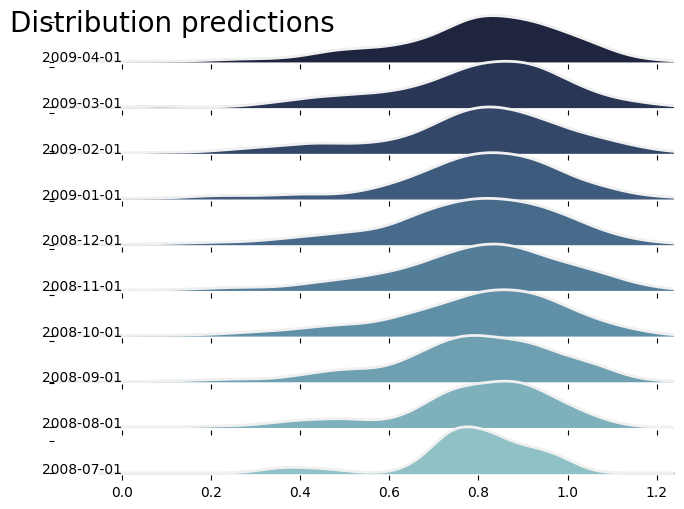

In [14]:
gs = (grid_spec.GridSpec(len(pred), 1))
fig = plt.figure(figsize=(8,6))
ax_objs = []
palette = sns.cubehelix_palette(10, rot=-.25, light=.7, reverse=True)
index = pred.index.astype(str).to_list()[::-1]

for i, step in enumerate(index):

    # creating new axes object and appending to ax_objs
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

    # plotting the distribution
    plot = pred.loc[step].plot.kde(ax=ax_objs[-1], color="#f0f0f0", lw=2)

    # grabbing x and y data from the kde plot
    x = plot.get_children()[0]._x
    y = plot.get_children()[0]._y

    # filling the space beneath the distribution
    ax_objs[-1].fill_between(x, y, color=palette[i])

    # setting uniform x and y lims
    ax_objs[-1].set_xlim(pred.values.min(), pred.values.max())
    # ax_objs[-1].set_ylim(0,2.2)

    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove borders, axis ticks, and labels
    ax_objs[-1].set_yticklabels([])
    ax_objs[-1].set_ylabel('')

    if i == len(pred)-1:
        pass
    else:
        ax_objs[-1].set_xticklabels([])

    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)

    ax_objs[-1].text(0, 0, str(step), fontsize=10, ha="right")

gs.update(hspace=-0.1)

fig.text(0.07,0.85,"Distribution predictions",fontsize=20)

plt.tight_layout()
plt.show()

In [15]:
def plot_prediction_distributions(bootstrapping_predictions: pd.DataFrame, **fig_kw):
    """
    Parameters
    ----------
    bootstrapping_predictions : pandas DataFrame
        Bootstrapping predictions created with `Forecaster.predict_bootstrapping`.

    **fig_kw : any
        All additional keyword arguments are passed to the `pyplot.figure` call.
    """

    index = bootstrapping_predictions.index.astype(str).to_list()[::-1]
    palette = sns.cubehelix_palette(len(index), rot=-.25, light=.7, reverse=False)
    fig, axs = plt.subplots(len(index), 1, sharex=True, **fig_kw)

    for i, step in enumerate(index):
        plot = bootstrapping_predictions.loc[step, :].plot.kde(ax=axs[i], color='w', lw=2)
        #Fill density area
        x = plot.get_children()[0]._x
        y = plot.get_children()[0]._y
        axs[i].fill_between(x, y, color=palette[i])
        prediction_mean = bootstrapping_predictions.loc[step, :].mean()
        
        # Closest point on x to the prediction mean
        idx = np.abs(x - prediction_mean).argmin()
        axs[i].vlines(x[idx], ymin=0, ymax=y[idx], linestyle="dashed", color='w')

        axs[i].spines['top'].set_visible(False)
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['bottom'].set_visible(False)
        axs[i].spines['left'].set_visible(False)
        axs[i].set_yticklabels([])
        axs[i].set_ylabel(step, rotation='horizontal', fontsize=8, va="bottom", ha='left')

    fig.subplots_adjust(hspace=-0)
    fig.suptitle('Forecasting distribution per step')

    return fig


In [16]:
pred.iloc[:2,:]

,pred_boot_0,pred_boot_1,pred_boot_2,pred_boot_3,pred_boot_4,pred_boot_5,pred_boot_6,pred_boot_7,pred_boot_8,pred_boot_9,...,pred_boot_490,pred_boot_491,pred_boot_492,pred_boot_493,pred_boot_494,pred_boot_495,pred_boot_496,pred_boot_497,pred_boot_498,pred_boot_499
2008-07-01,0.728822,0.737767,0.803769,0.735674,0.806414,0.833497,0.703955,0.957734,0.743416,0.828267,...,1.009476,0.984308,0.871057,0.382840,0.823742,0.984484,0.734131,0.929966,0.851741,0.833465
2008-08-01,0.922899,0.947186,0.789037,0.879750,0.906976,0.808887,0.753895,0.998746,0.675858,0.831930,...,0.871087,1.030537,0.785598,0.459338,0.869021,0.854388,0.801924,0.837748,0.873218,0.757491


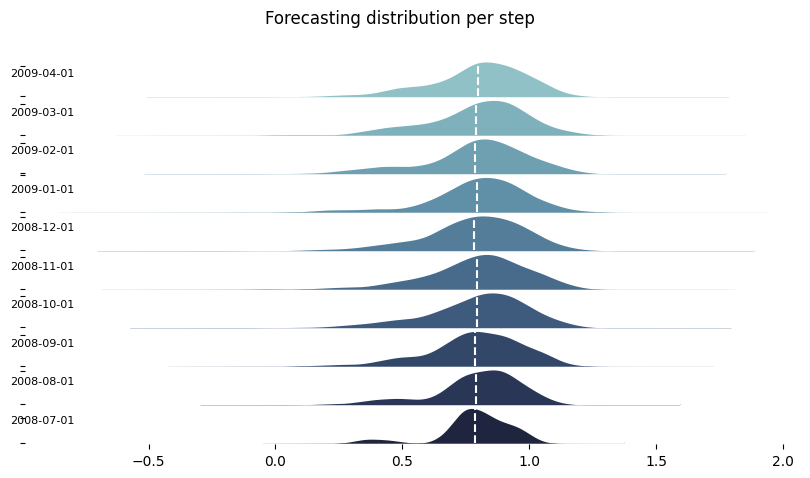

In [17]:
_ = plot_prediction_distributions(pred, figsize=(10, 5))

In [18]:
# def plot_prediction_distributions(bootstrapping_predictions):
#     """
    

#     Parameters
#     ----------
#     bootstrapping_predictions : pandas DataFrame
#         _description_
#     """

#     df = bootstrapping_predictions.stack().droplevel(level=1, axis=0).to_frame(name='pred')
#     df.index.name='step'
#     df = df.reset_index()
#     df['step'] = df['step'].astype(str)
#     df

#     sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})
#     palette = sns.cubehelix_palette(10, rot=-.25, light=.7, reverse=True)
#     row_order = list(df.step.unique())
#     row_order.reverse()
#     g = sns.FacetGrid(df, palette=palette, row="step", hue="step", aspect=20, height=0.8, row_order=row_order)
#     g.map_dataframe(sns.kdeplot, x="pred", fill=True, alpha=1)
#     g.map_dataframe(sns.kdeplot, x="pred", color='w', lw=2)
#     def label(x, color, label):
#         ax = plt.gca()
#         ax.text(0, .2, label, color='black', fontsize=13,
#                 ha="left", va="center", transform=ax.transAxes)
        
#     g.map(label, "step")
#     g.fig.subplots_adjust(hspace=-.5)
#     g.set_titles("")
#     g.set(yticks=[], xlabel="pred")
#     g.despine(left=True)
#     plt.suptitle('Prediction distribution', y=0.98)
    
#     return g


# plot = plot_prediction_distributions(pred)